<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

import nltk

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
print(dataset['train'][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 32


for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language = 'russian')]
        )

sentences = sentences[::2]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 136442


In [ ]:
sentences

['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 'customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" i really had to see this for myself.<br /><br />the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life.',
 'in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />what kills me about i am curious-yellow is that 40 years ago, this was considered pornographic.',
 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.',
 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.',
 '"i am curious: yellow" is a risible and pretentious steaming pile.',
 

Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

for sentence in sentences:
  words_list = word_tokenize(sentence)
  if (len(words_list) < word_threshold):
    for word in words_list:
      words[word] += 1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab_size = 10000

most_common_words = [word for word, _ in words.most_common(vocab_size)]

vocab = set(most_common_words)
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4
vocab_size += 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 10004


In [ ]:
vocab

{'emperor',
 'something',
 'funeral',
 'uniform',
 'not',
 'stabs',
 'admirer',
 '8',
 'knightley',
 'experimentation',
 'describing',
 'certainly',
 'walt',
 'massive',
 'saddest',
 'rocket',
 'characters',
 'rich',
 'distance',
 'marilyn',
 'rangers',
 'terrified',
 'gimmicks',
 'woefully',
 'golf',
 'splash',
 'soul',
 'gimmick',
 'divided',
 'considers',
 'dangers',
 'newcomer',
 'businessman',
 'aging',
 'mention',
 'unto',
 'stifler',
 'gates',
 'vows',
 'sci',
 'dibiase',
 'lose',
 'shootout',
 'robin',
 'vanessa',
 'daniels',
 'harm',
 'typical',
 'working',
 'date',
 'highlights',
 'cure',
 'eagerly',
 'record',
 'marching',
 'emphasis',
 'wishing',
 'shocking',
 'laughed',
 'attended',
 'branagh',
 'murdering',
 'progress',
 'grabs',
 'anthony',
 'mahatma',
 'diversion',
 'wastes',
 'ambitions',
 'abc',
 'lord',
 'hardy',
 'central',
 'resembling',
 'raid',
 'off-screen',
 'alarming',
 'thoroughly',
 'chewing',
 'kyle',
 'whatsoever',
 'swim',
 'fortune',
 'fast-forward',
 't

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        sentence = self.data[idx]
        words = word_tokenize(sentence)

        tokenized_sentence = [self.bos_id]  # Начало последовательности

        for word in words:
            if word in word2ind:
                tokenized_sentence.append(word2ind[word])
            else:
                tokenized_sentence.append(self.unk_id)

        tokenized_sentence.append(self.eos_id)  # Конец последовательности

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
train_sentences

['well maybe there ought to be.',
 '7/10',
 'broadcast film critics association awards for best costume design, also nominated for best actress emily blunt.',
 "one, it's irresponsible (and batman is everything, but irresponsible), and two, it's not what happened in the comics, if we are to remain faithful to them.<br /><br />batman - the animated series made history, with its animation, its stories and its characters... that really was a legend of batman.",
 "including loads of vast landscapes especially helps to minimise the costs of rendering.<br /><br />pixar films shine with technical brilliance, this one shines with effective uses of technical know-how.<br /><br />enough technical babble, the film's entertaining, family-friendly and sometimes just hilariously funny.",
 'they screwed up this story!',
 "what's important is our message and what we stand for.",
 "i guess the actress really didn't know which guy was which.",
 "but these scenes are about as cool as the stupid hardbody'

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
num_epoch = 5
losses = []
perplexities = []

def train_model(model, train_dataloader, criterion, optimizer, epoches = 5):

    for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      total_loss = 0
      progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epoch}')

      for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
          optimizer.zero_grad()
          outputs = model(batch['input_ids'])
          loss = criterion(outputs.reshape(-1, outputs.size(-1)), batch['target_ids'].reshape(-1))

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
          optimizer.step()

          total_loss += loss.item()
          progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
          epoch_losses.append(loss.item())

      losses.append(total_loss / len(epoch_losses))
      perplexities.append(evaluate(model, criterion, eval_dataloader))


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, dropout_p = 0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.RNN(hidden_dim, hidden_dim, batch_first = True)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(dropout_p)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
import torch
import gc

# Принудительная очистка памяти
torch.cuda.empty_cache()
gc.collect()

# Проверка свободной памяти
print(f"Free GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Добавьте в начало кода
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Используем более эффективные вычисления
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

Free GPU memory: 0.00 GB


In [ ]:
print(torch.__version__)  # Версия PyTorch
print(torch.version.cuda)  # Версия CUDA


2.8.0+cu126
12.6


In [ ]:
! PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
perplexities = []
losses = []

hidden_dim = 32

model = LanguageModel(hidden_dim).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

train_model(model, train_dataloader, criterion, optimizer, epoches=5)

Epoch 1/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6823 [00:00<?, ?it/s]

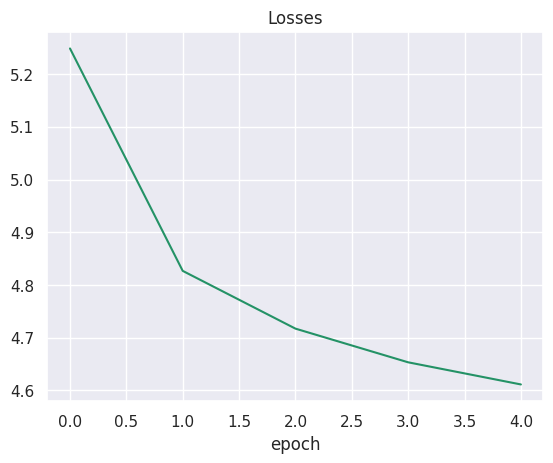

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

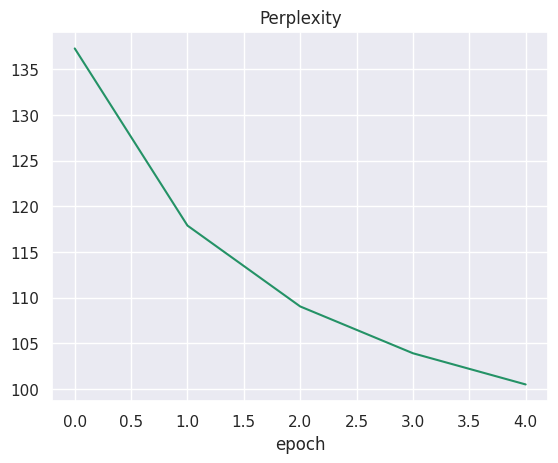

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

сгененируем несколько предложений

In [ ]:
def generate_sequence(model, starting_seq, max_seq_len = 50) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()

    with torch.no_grad() :
      for i in range(max_seq_len):
        next_word_distribution = model(input_ids)[-1]
        next_word = next_word_distribution.squeeze().argmax()
        input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

        if next_word.item() == word2ind['<eos>']:
            break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])
    return words


In [ ]:
generate_sequence(model, 'Hello, my favorite movie is')

'<bos> <unk> my favorite movie is a <unk> <unk> . <eos>'

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

попробуем увеличить число скрытых слоев и посмотреть как это отразится на перплексии (число эпох оставимм прежним)

In [ ]:
hidden_dim = 128

perplexities = []
losses = []

model1 = LanguageModel(hidden_dim).to(device)
optimizer = torch.optim.Adam(model1.parameters())

train_model(model1, train_dataloader, criterion, optimizer, epoches=5)


Epoch 1/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6823 [00:00<?, ?it/s]

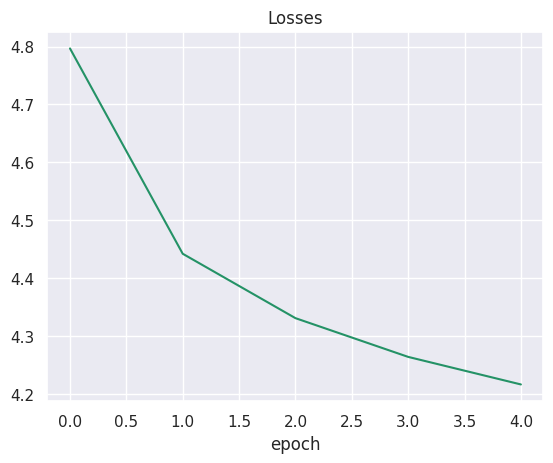

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

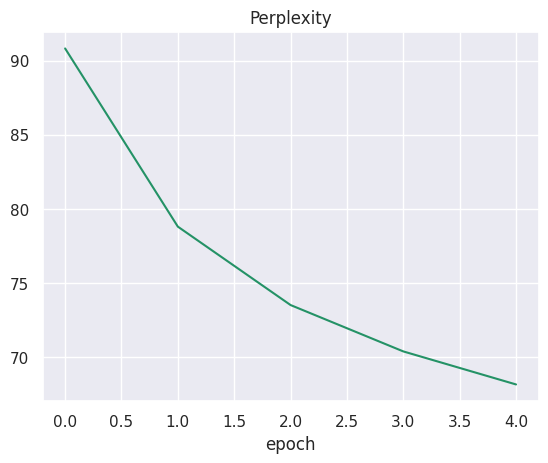

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
generate_sequence(model1, 'Hello, my favorite movie is')

'<bos> <unk> my favorite movie is that the film is a <unk> <unk> of <unk> <unk> < br / > < br / > the film is a <unk> <unk> of <unk> <unk> , and the <unk> of the <unk> <unk> , and the <unk> of the <unk> <unk> , and the <unk> of the <unk>'

видим, что перплексия и в целом качество предскзаний модели немного улучшились. попробуем теперь RNN слой в модели заменить на LSTM

In [ ]:
class LanguageLSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers = 1, dropout_p = 0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first = True)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(dropout_p)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
hidden_dim = 128

perplexities = []
losses = []

model_lstm = LanguageLSTMModel(hidden_dim).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters())

train_model(model_lstm, train_dataloader, criterion, optimizer, epoches=5)

Epoch 1/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6823 [00:00<?, ?it/s]

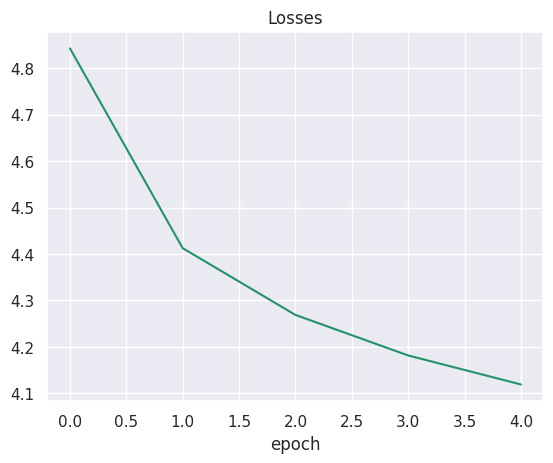

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

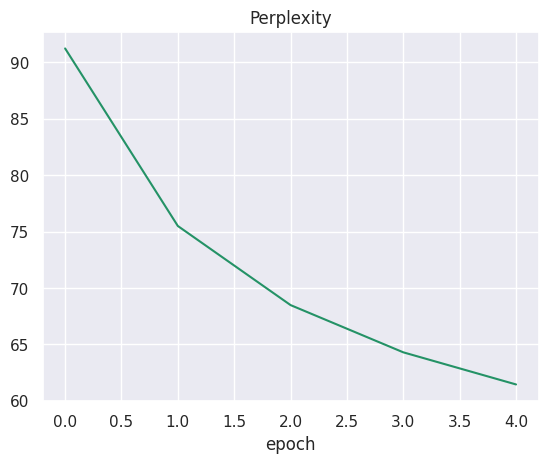

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
generate_sequence(model_lstm, 'Hello, my favorite movie is')

'<bos> <unk> my favorite movie is a <unk> <unk> , and the <unk> of the <unk> are <unk> . <eos>'

видим что перплексия стала порядка 60, попробуем увеличить количество этоп до 10 (заметно небольшое недообучение) а также увеличить число скрытых слоев.

In [ ]:
hidden_dim = 256

perplexities = []
losses = []

model_lstm = LanguageLSTMModel(hidden_dim).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters())

train_model(model_lstm, train_dataloader, criterion, optimizer, epoches=10)

Epoch 1/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6823 [00:00<?, ?it/s]

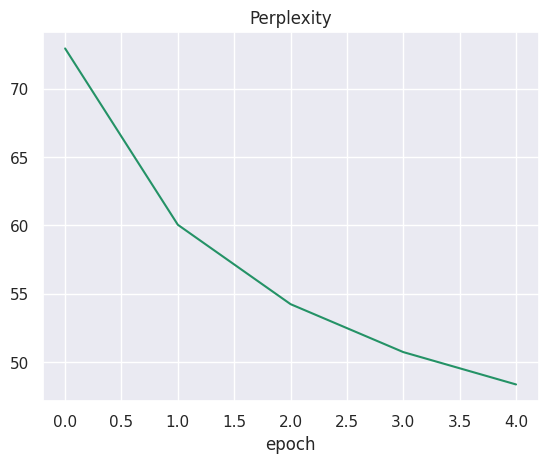

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

теперь изменим параметр layers_num на 2, что создаст нам еще одну LSTM сеть поверх предыдущей и посмотрим как изменится метрика

In [ ]:
hidden_dim = 256

perplexities = []
losses = []

model_lstm = LanguageLSTMModel(hidden_dim, num_layers=2).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters())

train_model(model_lstm, train_dataloader, criterion, optimizer, epoches=10)

Epoch 1/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/6823 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/6823 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/6823 [00:00<?, ?it/s]

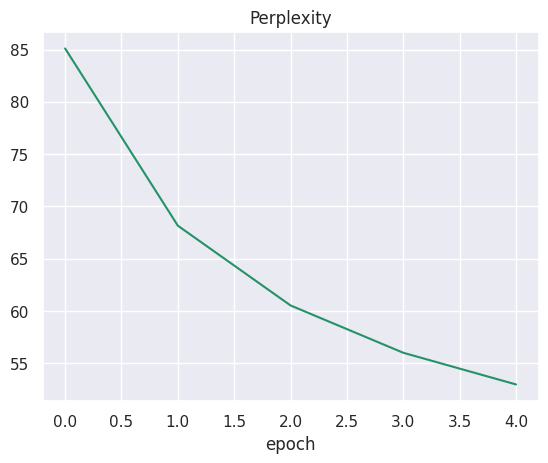

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Попробовали различные вариации моделей, начиная от однослойной RNN заканчивая двуслойной LSTM.
Большое влияние на перплексию модели оказало именно число скрытых состояний (что уменьшило перплексию с 100 до 70).
Также из исследования ясно, что сложные LSTM модели гораздо лучше српавляются с языковым поделированием чем простые RNN, чего и стоило ожидать (перплексия 55 против 70)
улучшить качество генерации можно увеличив число слов в словаре и количество сркытых слоев самой модели